In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

from herbie import Herbie
from paint.standard2 import cm_tmp, cm_wind, cm_wave_height, cm_pcp
from toolbox import EasyMap, pc
import xarray as xr
import pandas as pd
import datetime
from datetime import timedelta
import time
import pickle

The NOAA GEFS numerical weather prediction (NWP) model is a 30-member ensemble version of the GFS model. NOAA has this description:
> The GEFS attempts to quantify the amount of uncertainty in a forecast by generating an ensemble of multiple forecasts, each minutely different, or perturbed, from the original observations. With global coverage, GEFS is produced four times a day with weather forecasts going out to 16 days.

We will look at the fleet-wide weighted average standard deviation of the Total Cloud Cover (TCC) percentage across all 30 members, weighted by the solar plant capacities. For example, if all 30 members forecast that a given location and time will have no clouds (TCC = 0%), then the standard deviation will be *low*, so we assume that our power forecast has *low uncertainty*. If there is significant disagreement between the 30 members (some members forecast no or low cloud cover, while others forecast high cloud cover), then the standard deviation will be *high*, and we assume that any forecast will have *high uncertainty*. 

We use TCC instead of irradiance for two reasons: 
 1) GFS is known to have issues with modeling irradiance, and 
 2) We are looking at *relative* uncertainty, and using TCC means we don't have to normalize irradiance to clear sky irradiance. 

outline:
- pull TCC and show what's in it
- make a sample map
- illustrate site-weighting for a single member
- std across members...

Let's load the same list of plants we used earlier:

In [2]:
plants_df = pd.read_csv(r'C:\Users\willh\Documents\Python Scripts\herbie_examples\pv_fleet_metadata_rev3.csv') # read in as a Pandas DataFrame
plants_df = plants_df[plants_df['ac_capacity']>=10].copy().reset_index()
num_plants = len(plants_df.index) # number of plants

In [5]:
#
def get_tcc_fcast(init_time,fxx,plants_df,num_members=30,
                   verbose=False,remove_grib=False,overwrite=False,
                   region_extent=[0,359.999,-90,90]):
    # list of GEFS ensemble members, e.g., 'p01', 'p02', etc.
    member_list = [f"p{x:02d}" for x in range(1, num_members+1)]

    # GEFS uses longitudes in [0,360), so use modulo to convert lon to be 0 <= lon < 360
    lon_gefs = [(x + 360) % 360 for x in plants_df.longitude]

    d={}
    data=[]
    member_site_tcc = np.empty([num_members, len(plants_df.index)])
    for x in range(0, num_members):
        d[x] = Herbie(init_time, model="gefs", product="atmos.5", 
                            member=member_list[x], fxx=fxx,
                            verbose=verbose).xarray("TCDC",
                                                     remove_grib=remove_grib,
                                                     overwrite=overwrite)
        d[x] = d[x].rename({'tcc':'tcc_' + member_list[x]})
        d[x] = d[x].drop_vars(['number', 'atmosphere', 'gribfile_projection'])
    ds = xr.merge([d[i] for i in d])

    # GEFS uses longitudes in [0,360), so use modulo to convert lon to be 0 <= lon < 360
    lon_gefs = [(x + 360) % 360 for x in plants_df.longitude]

    # select the whole list of sites at once
    lats = xr.DataArray(plants_df.latitude.values, dims='plant_number') 
    lons = xr.DataArray(lon_gefs, dims='plant_number')
    df = ds.sel(latitude = lats, longitude = lons, method = 'nearest').to_dataframe()

    # assign ac capacity based on plant_number and index in plants_df
    df = df.merge(plants_df[['ac_capacity']], left_on='plant_number', right_index=True)

    # rename latitude, longitude columns to note that they came from the GEFS coordinates
    # rename time to add utc
    df = df.rename(columns={'latitude':'gefs_latitude','longitude':'gefs_longitude',
                            'time':'time_utc'
                })

    # remove index
    df = df.reset_index()

    # loop through unique forecasts (unique 'time_utc' and 'step' values)
    temp = {}
    i=0
    for time_utc in df['time_utc'].unique():
        for step in df['step'].unique():
            
            df_temp = df[(df['time_utc']==time_utc) & (df['step']==step)]
            out = df_temp.filter(regex='tcc').multiply(plants_df['ac_capacity'].values,axis='index').sum()/plants_df['ac_capacity'].sum()
            temp[i] = out.to_frame().T
            temp[i].insert(0, 'time_utc', time_utc)
            temp[i].insert(1, 'step', step)
            # because each time, step combination has a unique valid_time:
            valid_time = df_temp['valid_time'].unique()[0]
            # add valid_time
            temp[i].insert(2, 'valid_time', valid_time)
            i += 1

    # concatenate results
    weighted_avg_tcc = pd.concat(temp)
    del temp, df_temp, df

    # rename columns, set indices
    weighted_avg_tcc.rename(columns={'valid_time':'valid_time_utc_end_of_interval'},
                                    inplace=True)
    weighted_avg_tcc.set_index(['time_utc', 'step','valid_time_utc_end_of_interval'],inplace=True)

    # calculate stdev of weighted avg tcc for each valid_time_utc
    weighted_avg_tcc.insert(0,'tcc_std',weighted_avg_tcc.filter(regex='tcc').std(axis=1))

    weighted_avg_tcc = weighted_avg_tcc.reset_index().set_index('valid_time_utc_end_of_interval')

    # slice to region of interest
    # lat, lon extent for region of interest in GEFS coordinates
    # longitude has to be between 0 and 360
    min_lon = (region_extent[0]+360) % 360
    max_lon = (region_extent[1]+360) % 360
    min_lat = region_extent[2]
    max_lat = region_extent[3]

    # slice to region extent
    # note that lat is sliced max to min because of order that latitude is stored in with GEFS
    # (I think...)
    ds = ds.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon,max_lon))
    # ds = ds.rename({'tcc':'tcc_' + member_list})
    # ds = ds.drop_vars(['number', 'atmosphere', 'gribfile_projection'])

    ds.close()
    return weighted_avg_tcc, ds

In [ ]:
# plotting helper function
def make_plot(ds, member, cbar=True):
    ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10, 10]).STATES().BORDERS().ax
    p = ax.pcolormesh(
        ds.longitude, ds.latitude, ds['tcc_'+member], transform=pc, cmap="Greens", vmin=0
    )
    if cbar==True:
        plt.colorbar(
            p,
            ax=ax,
            orientation="horizontal",
            pad=0.01,
            shrink=0.8,
            label=f"{ds['tcc_'+member].GRIB_name} ({ds['tcc_'+member].GRIB_units})",
    )
    plt.scatter(plants_df.longitude, plants_df.latitude, s=plants_df.ac_capacity,
                edgecolors='black', transform=pc)
    ax.set_title(
        f"{ds.model.upper()} - Ensemble Member {member} \
        \nInitialized: {ds.time.dt.strftime('%H:%M UTC %d %b %Y').item()} \
        \nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
        loc="left",
    )
    ax.set_title(ds['tcc_'+member].GRIB_name, loc="right")
    plt.show()

In [6]:
num_members = 4 # Number of ensemble members to pull, max of 30
fxx = 36
# lat, lon extent for region of interest
# (left lon, right lon, lower lat, upper lat)
region_extent = [-92, -80, 29.5, 35]

Could not find variable corresponding to the value of grid_mapping: gribfile_projection
c:\Users\willh\miniforge3\envs\pvlib_herbie_env2\Lib\site-packages\herbie\accessors.py:141: UserWarning: More than one time coordinate present for variable  "tcc_p01".
  ds = ds.metpy.parse_cf(varname=variables)
Could not find variable corresponding to the value of grid_mapping: gribfile_projection
Could not find variable corresponding to the value of grid_mapping: gribfile_projection
Could not find variable corresponding to the value of grid_mapping: gribfile_projection


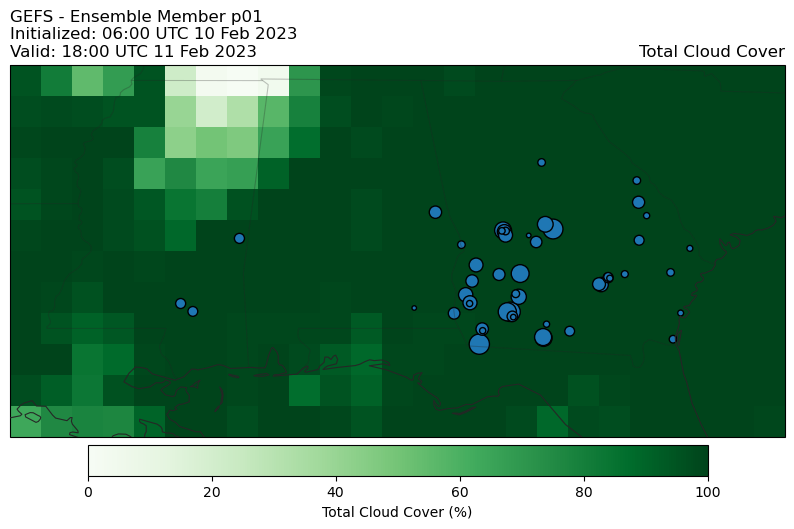

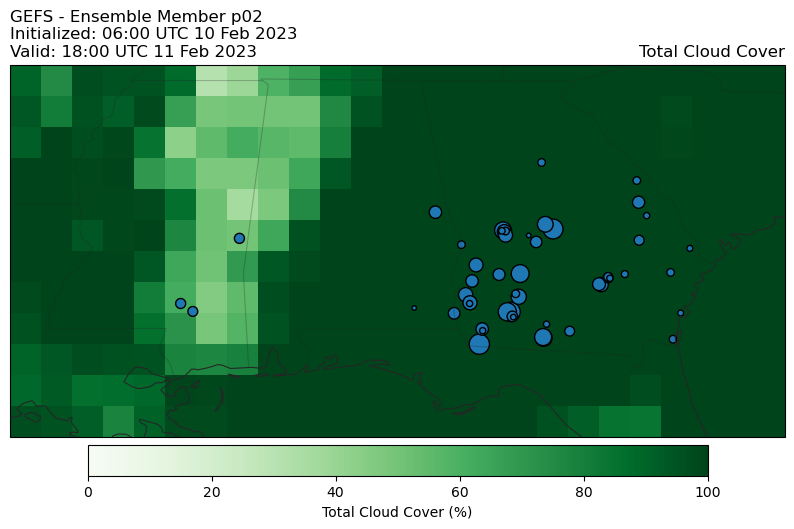

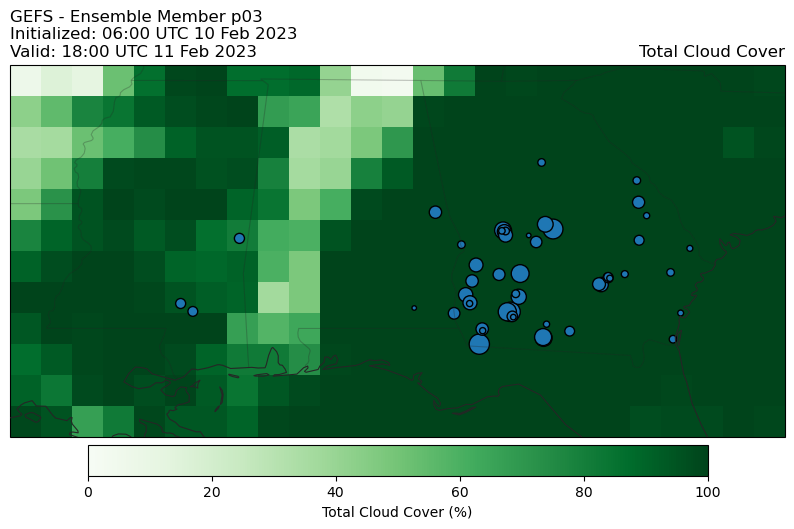

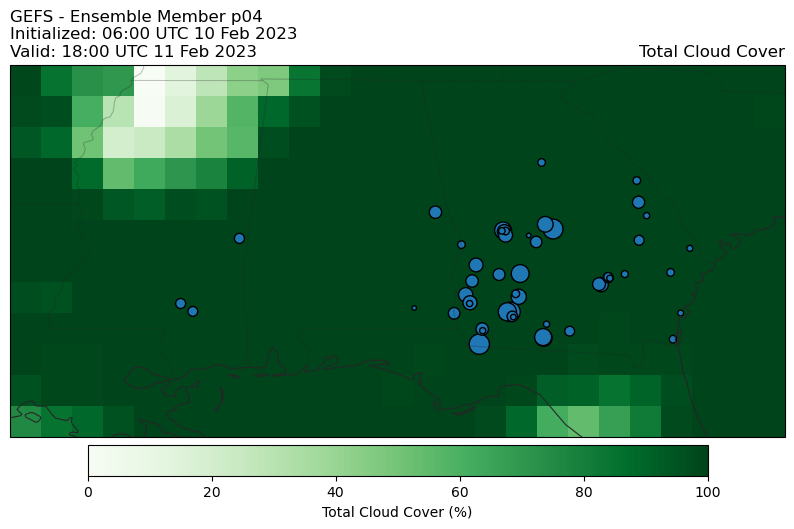

In [8]:
# example low solar, low uncertainty day
init_time = '2023-02-10T06:00:00'

weighted_avg_tcc, ds = get_tcc_fcast(init_time,fxx,plants_df,num_members=num_members,
                   verbose=False,remove_grib=False,overwrite=False, region_extent=region_extent)

make_plot(ds, member = 'p01')
make_plot(ds, member = 'p02')
make_plot(ds, member = 'p03')
make_plot(ds, member = 'p04')